In [1]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms 
import pandas as pd
import PIL
import numpy as np 
import matplotlib.pyplot as plt
from easyimages import EasyImageList
from torch import nn
import torch
from sklearn.metrics import accuracy_score, classification_report, log_loss
import torch.nn.functional as F
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
import ignite

### Define the new dataset

Keep in mind we are inheriting the Dataset base-class. And we have to override 2 methods:
 - \____len____
 - \____getitem____

1. load_image_and_target reads the data from the csv file and converts the image array into a PIL object - this is not mandatory but useful, as many handy functions like transform, operate on PIL.Images
2. getitem, takes a index and it should properly return for every number between (0, and len)
3. len should return the number of samples (images) in your dataset

In [2]:
label_dict = {
 0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'
}

class FashionMnist(Dataset):

    def __len__(self):
        return len(self.metadata_df)

    def __init__(self, metadata_df,
                 transform=None):
        
        self.metadata_df = metadata_df.copy()
        self.transform = transform
    
    def load_image_and_target(self,index):
        # .iloc is short for integer loc it returns a row of data based on its ored not index-value(if not the same)
        oneimage = self.metadata_df.iloc[index]
        image, y = PIL.Image.fromarray(
            np.array(oneimage[1:]).reshape(28, 28).astype('uint8'), 'L'), oneimage[0]
        
        return image, y
    
    def _load_image_metadata(self, index):
        
        image_path = df.iloc[index]
        
        image = PIL.Image.open(image_path)
        meta_data = image.meta_data
        
        image, metada 
        
    def __getitem__(self, index):
        X, y = self.load_image_and_target(index)
        # We can transform the output images here, cast to torch data-format and/or do augmentations
        X = self.transform(X)
            
        return X, y

    def collate_func(self, batch):
        pass

    
dftrain = pd.read_csv('fashion-mnist_train.csv').sample(frac=1)
dftest = pd.read_csv('fashion-mnist_test.csv').sample(frac=1)

transform_train = transforms.Compose([transforms.ToTensor()])
fmnist_train = FashionMnist(dftrain, transform=transform_train)

transform_test = transforms.Compose([transforms.ToTensor()])
fmnist_test = FashionMnist(dftest, transform=transform_test)

In [3]:
X, y = fmnist_test[0]
X.shape

torch.Size([1, 28, 28])

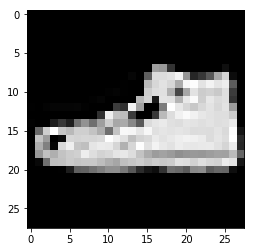

In [4]:
one_sample_image = dftrain.iloc[20].tolist()
label, image =  one_sample_image[0], one_sample_image[1:]
label
im = np.array(image).reshape((28, 28))

plt.imshow(im, cmap='gray')


### our datasets supports getitem wich means we can do:

In [5]:
image, label = fmnist_train[0]
print(type(image))
print(type(label), label)

image, label = fmnist_train.load_image_and_target(0)
print(type(image), image)

<class 'torch.Tensor'>
<class 'numpy.int64'> 4
<class 'PIL.Image.Image'> <PIL.Image.Image image mode=L size=28x28 at 0x7F271DFCFCC0>


In [6]:
fmnist_dl = DataLoader(fmnist_train, batch_size=32, num_workers=10)
# batch_iterator = iter(fmnist_dl)
# X, y = next(batch_iterator)

# for batch in fmnist_dl:
#     break
# for batch in fmnist_dl:
#     break
    
# print("y:",batch[1].shape)
# print("X: ", batch[0].shape)


### Explore your dataset
Its always good to start with getting some inside about your dataset. Thats usuall much easier and less important in image datasets - but it does not mean you should not do it.

Things you should always think about working with an image dataset are:
- Check target distribiution (counts) do you see a strong imbalance?
- Check sizes of images, if not all images are of the same size you might destroy your data with wrong transformations
 

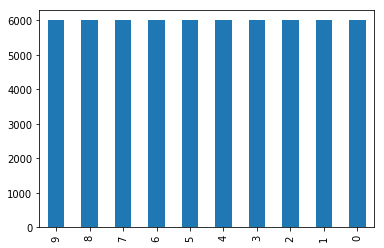

In [7]:
dftrain.label.value_counts().plot(kind='bar')

### visualize a batch
Its always a good idea to sanity check the output of our loaders

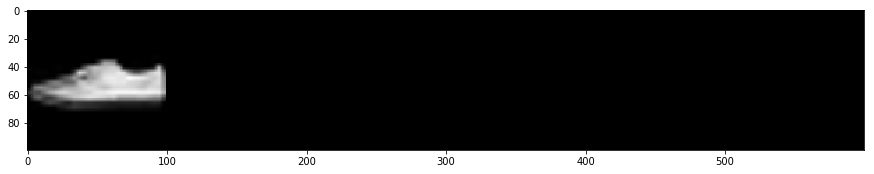

In [8]:
im = EasyImageList.from_torch_batch(X.repeat(1,3,1,1), # we need to add 3 channels to the images
                                    mean=None, std=None)
im.numpy_grid()

### Define your model architecture
As a baseline model dont  overcomplicate, either use some very simple architecture or go with something well established like resnet. There will be time to go more fancy

Here we define a model with two CONV blocks comprising of a typical:  
*Conv>BN>RELU>POOL* setting

In [9]:
class SimpleCNN(nn.Module):
    def __init__(self, num_of_class):
        super(SimpleCNN, self).__init__()
    
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.fc = nn.Linear(7 * 7 * 32, num_of_class)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
                
        out = out.reshape(out.size(0), -1)
        
        out = self.fc(out)
        return out
    
    


In [10]:
# Always check your model are you atleasy able to make a forward pass and shapes match your expectations?
image = torch.randn(32, 1, 28, 28)
cnn = SimpleCNN(10)
output = cnn(image)
print("input shape:")
print(image.shape)
print("output shape:")
print(output.shape)

input shape:
torch.Size([32, 1, 28, 28])
output shape:
torch.Size([32, 10])


### Define your loss function / crieterion and optimizer
Its a good idea to create some dummy data and pass it trough the cost function to make sure you uderstand what the shapes shoudl be

In case of CrossEntropyLosss We want our predictions to be of shape (BATCH_SIZE, N_CLASSES) and y_true of shape (BS) 
(Basically a vector of number that corespond to the class) 


In [11]:
LR= 0.001
BATCH_SIZE = 16
DATASET_USAGE_SIZE = 0.05

MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
RESIZE = 28

cnn = SimpleCNN(10)

OPTIMIZER = 'Adam' # one of ['ASGD','Adadelta', 'Adagrad','Adam', 'Adamax','LBFGS', 'RMSprop','Rprop','SGD',SparseAdam']
optimizer = getattr(torch.optim, OPTIMIZER)(cnn.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

cnn.to(DEVICE)

# Create dataset loaders

dftrain = pd.read_csv('fashion-mnist_train.csv').sample(frac=DATASET_USAGE_SIZE)
dftest = pd.read_csv('fashion-mnist_test.csv').sample(frac=0.1)

transform_train = transforms.Compose([transforms.Resize(RESIZE), transforms.ToTensor()])
fmnist_train = FashionMnist(dftrain, transform=transform_train)

transform_test = transforms.Compose([transforms.Resize(RESIZE), transforms.ToTensor()])
fmnist_test = FashionMnist(dftest, transform=transform_test)

fmnist_train_dl = DataLoader(fmnist_train, batch_size=BATCH_SIZE)
fmnist_test_dl = DataLoader(fmnist_test, batch_size=BATCH_SIZE)

# Lets try to use the criterion with dummy data
yp = torch.randn(BATCH_SIZE, 10)
yt = torch.randint(10, (BATCH_SIZE,))
criterion(yp, yt.long())

len(fmnist_train_dl)
len(dftrain)

3000

In [12]:
from ignite.engine import create_supervised_evaluator, create_supervised_trainer
from ignite.metrics import CategoricalAccuracy, Loss
from ignite.engine import Events
from ignite.handlers import EarlyStopping

In [13]:
trainer = create_supervised_trainer(cnn, optimizer,criterion, DEVICE)
evaluator = create_supervised_evaluator(cnn, metrics={'accuracy':CategoricalAccuracy(), 'loss':Loss(criterion)}, device=DEVICE)

In [14]:
@trainer.on(Events.ITERATION_COMPLETED)
def validate(trainer):
    evaluator.run(fmnist_test_dl)
    metrics = evaluator.state.metrics
    print('acc: ', metrics['loss'])

In [15]:
trainer.run(fmnist_test_dl, max_epochs=10)

acc:  2.2969395713806153
acc:  2.292651477813721
acc:  2.287855712890625
acc:  2.2817430744171143
acc:  2.2746126441955568
acc:  2.2664117259979246
acc:  2.256345142364502
acc:  2.245388935089111
acc:  2.232727039337158
acc:  2.2170041465759276
acc:  2.1996250190734865
acc:  2.179084987640381
acc:  2.1556287994384764
acc:  2.1299215965270997
acc:  2.101634267807007
acc:  2.0697844886779784
acc:  2.035387939453125
acc:  1.9987571907043458
acc:  1.9596436071395873
acc:  1.9182288246154786
acc:  1.8780220537185668
acc:  1.833820671081543
acc:  1.7889170608520508
acc:  1.7402645149230958
acc:  1.6896177082061767
acc:  1.64193660736084
acc:  1.5941229171752929
acc:  1.5479445514678956
acc:  1.5032747602462768
acc:  1.456867000579834
acc:  1.4092307243347169
acc:  1.3524359216690063
acc:  1.293808084487915
acc:  1.2397232398986817
acc:  1.1880430569648743
acc:  1.140977388858795
acc:  1.1019176411628724
acc:  1.0674578943252564
acc:  1.0355768251419066
acc:  1.0009836177825928
acc:  0.969986

acc:  0.21602005767822266
acc:  0.212501788854599
acc:  0.20990020895004272
acc:  0.2091829035282135
acc:  0.21027391493320466
acc:  0.21602606713771821
acc:  0.2268416769504547
acc:  0.2380952285528183
acc:  0.24850905752182006
acc:  0.25552075266838076
acc:  0.26601533067226407
acc:  0.26558436381816863
acc:  0.2607548176050186
acc:  0.2530714873075485
acc:  0.2339248012304306
acc:  0.21691953957080842
acc:  0.2225233370065689
acc:  0.23275714325904845
acc:  0.2400583349466324
acc:  0.2544199423789978
acc:  0.2640138976573944
acc:  0.26106300723552706
acc:  0.26181765311956406
acc:  0.253463743686676
acc:  0.250648090839386
acc:  0.24511448085308074
acc:  0.23248498702049256
acc:  0.218933899641037
acc:  0.20760897463560105
acc:  0.19830839073657988
acc:  0.19513741767406464
acc:  0.19447961544990539
acc:  0.1923313893675804
acc:  0.19502879971265794
acc:  0.1983224893808365
acc:  0.19860916286706926
acc:  0.1972240034341812
acc:  0.194014073908329
acc:  0.1929402129650116
acc:  0.19